<a href="https://colab.research.google.com/github/ValeryNikiforov/Speech-Emotion-Recognition/blob/master/SER_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as data
import torch.optim as optim
import numpy as np
import os
import scipy
import scipy.io.wavfile
from scipy.fftpack import dct
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import Audio
from sklearn.model_selection import train_test_split

In [ ]:
catalog_name = 'drive/My Drive/toronto_converted/'
catalog_name_rav = 'drive/My Drive/ravdess_converted/'
catalog_name_sav = 'drive/My Drive/savdee_converted/'

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
emotions = {'angry':0, 'disgust':1, 'fear':2, 'happy':3, 'neutral':4, 'ps':5, 'sad':6}
#01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised
emotions_ravdess = {'05':0, '07':1, '06':2, '03':3,'01':4, '04':6, '08':5}
emotions_savdee = {'a':0, 'd':1, 'f':2, 'h':3, 'n':4, 'su':5,'sa':6}

In [ ]:
'''
X_train = np.load("drive/My Drive/X_train.npy")
X_test = np.load("drive/My Drive/X_test.npy")
y_train = np.load("drive/My Drive/y_train.npy")
y_test = np.load("drive/My Drive/y_test.npy")
'''

'\nX_train = np.load("drive/My Drive/X_train.npy")\nX_test = np.load("drive/My Drive/X_test.npy")\ny_train = np.load("drive/My Drive/y_train.npy")\ny_test = np.load("drive/My Drive/y_test.npy")\n'

In [ ]:
X_raw_data = np.load("drive/My Drive/X_raw_data.npy")
y = np.load("drive/My Drive/y.npy")

(4528, 23879)


In [ ]:
import random
def freq_mask(spec, F=15, num_masks=2, replace_with_zero=False):
    cloned = spec.copy()
    num_mel_channels = np.shape(cloned)[0]
    
    for i in range(0, num_masks):        
        f =  random.randrange(1, F)
        f_zero =  random.randrange(1, num_mel_channels - f)

        # avoids randrange error if values are equal and range is empty
        if (f_zero == f_zero + f): return cloned

        mask_end =  random.randrange(f_zero, f_zero + f) 
        if (replace_with_zero):
          cloned[f_zero:mask_end] = np.random.uniform(0,10,np.shape(cloned[f_zero:mask_end])) 
          #cloned[f_zero:mask_end] = 0
        else: 
          cloned[f_zero:mask_end] = cloned.mean()
    
    return cloned

In [ ]:
def time_mask(spec, T=10, num_masks=1, replace_with_zero=False):
    cloned = spec.copy()
    len_spectro = np.shape(cloned)[1]
    
    for i in range(0, num_masks):
        t =  random.randrange(1, T)
        t_zero =  random.randrange(1, len_spectro - t)

        # avoids randrange error if values are equal and range is empty
        if (t_zero == t_zero + t): return cloned

        mask_end =  random.randrange(t_zero, t_zero + t)
        if (replace_with_zero):
          cloned[:,t_zero:mask_end] = np.random.uniform(0,25,np.shape(cloned[:,t_zero:mask_end]))  
          #cloned[:,t_zero:mask_end] = 0
        else: 
          cloned[:,t_zero:mask_end] = cloned.mean()
    return cloned

In [ ]:
def specaug(X,y):
  X_aug = np.copy(X)
  for i in range(0,np.shape(X)[0]):
    X_aug[i] = freq_mask(X[i])
    X_aug[i] = time_mask(X_aug[i])
  X = np.append(X,X_aug,axis=0)
  y = np.append(y,y,axis=0)
  del X_aug
  return X,y

In [ ]:
first_fragment_size = 297
sec_fragment_size = 200
def filterbanks(X_raw_data):
  frame_size = 0.025
  frame_stride = 0.01
  sample_rate = 8000
  num = np.shape(X_raw_data)[0]
  frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  
  X_frames = np.zeros((num,first_fragment_size,sec_fragment_size))
  for i in tqdm(range(len(X_raw_data))):
    signal_length = len(X_raw_data[i])
    frame_length = int(round(frame_length))
    frame_step = int(round(frame_step))
 
    num_frames = 1+int(np.ceil(float(signal_length - frame_length) / frame_step)) 
    pad_signal_length = int((num_frames-1) * frame_step + frame_length)
    z = np.zeros((pad_signal_length - signal_length))
    pad_signal = np.append(X_raw_data[i], z) 

    for j in range(len( X_frames[i])):
      X_frames[i,j] *= np.hamming(frame_length)
  
    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    X_frames[i] = pad_signal[indices.astype(np.int32, copy=False)]
  del z, pad_signal, X_raw_data
  NFFT = 512
  pow_frames = np.zeros((num,first_fragment_size,257))
  for i in tqdm(range(len(X_frames))):
    pow_frames[i] = ((1.0 / NFFT) * (np.square(np.absolute(np.fft.rfft(X_frames[i], NFFT)))))
  del X_frames

  nfilt = 26
  low_freq_mel = 0
  high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700.)) 
  mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  
  hz_points = (700 * (10**(mel_points / 2595.0) - 1)) 
  bin = np.floor((NFFT + 1) * hz_points / sample_rate)

  fbanks = np.zeros([nfilt,NFFT // 2 + 1])
  for j in range(0, nfilt):
  
    for i in range(int(bin[j]), int(bin[j+1])):
            fbanks[j,i] = (i - bin[j]) / (bin[j+1]-bin[j])
    for i in range(int(bin[j+1]), int(bin[j+2])):
            fbanks[j,i] = (bin[j+2]-i) / (bin[j+2]-bin[j+1])
        
  print(np.shape(fbanks))        
  filter_banks = np.zeros((num,first_fragment_size,26))   
  energy = np.zeros((num,first_fragment_size))
  for i in tqdm(range(num)):
    filter_banks[i]= np.dot(pow_frames[i], fbanks.T)
    filter_banks[i] = np.where(filter_banks[i] == 0, np.finfo(float).eps, filter_banks[i])  
    energy[i] = np.sum(pow_frames[i],1) 
    energy[i] = np.where(energy[i] == 0,np.finfo(float).eps,energy[i])
  del pow_frames
  plt.imshow(filter_banks[300])
  return filter_banks, energy

In [ ]:
def mfcc(filter_banks, energy):
  num_ceps = 26
  mfcc_old = np.zeros((np.shape(filter_banks)[0], first_fragment_size, 26))
  _, nframes,ncoeff = np.shape(mfcc_old)
  n = np.arange(ncoeff)
  lift = 1 + (22/2.)*np.sin(np.pi*n/22)
  for i in range(np.shape(filter_banks)[0]):
    filter_banks[i]= np.log(filter_banks[i])
    mfcc_old[i] = dct(filter_banks[i], type=2, axis=1, norm='ortho')[:, : num_ceps]
    mfcc_old[i] = lift * mfcc_old[i]
    mfcc_old[i,:,0] = np.log(energy[i])
  plt.imshow(mfcc_old[300,:200,:].T)
  return  mfcc_old

In [ ]:
!pip install librosa==0.7.2 
import librosa
import librosa.display
def melspec(X_raw_data):
  X = np.ndarray((np.shape(X_raw_data)[0],128,47))
  for i in range(np.shape(X_raw_data)[0]):
    X[i] = librosa.feature.melspectrogram(X_raw_data[i], win_length=1024)
  X = np.where(X == 0, np.finfo(float).eps, X)
  X = 20*np.log10(X)  # dB
  return X

     |████████████████████████████████| 1.6MB 2.8MB/s 
  Created wheel for librosa: filename=librosa-0.7.2-cp36-none-any.whl size=1612885 sha256=6a9416501b3bd336f9c2cb0b1171fb46a6de1e4d4128d06ea7fe9e13a6ed2772
  Stored in directory: /root/.cache/pip/wheels/4c/6e/d7/bb93911540d2d1e44d690a1561871e5b6af82b69e80938abef
Successfully built librosa
  Found existing installation: librosa 0.6.3
    Uninstalling librosa-0.6.3:
      Successfully uninstalled librosa-0.6.3


In [ ]:
'''
X_train = X_raw_data[120:]
y_train = y[120:]
X_test = X_raw_data[:120]
y_test = y[:120]
'''
X_raw_data_pitched = np.load("drive/My Drive/X_raw_data_pitched.npy")
y_pitched = np.load("drive/My Drive/y_pitched.npy")
X_train, X_test, y_train, y_test = train_test_split(X_raw_data,y, test_size=0.2)
X_train = np.append(X_train,X_raw_data_pitched[120:],axis=0)
y_train = np.append(y_train,y_pitched[120:],axis=0)

  4%|▍         | 313/8030 [00:00<00:02, 3122.57it/s]

(26, 257)


  2%|▏         | 21/906 [00:00<00:04, 206.40it/s]

(8030, 297, 26)


 38%|███▊      | 347/906 [00:00<00:00, 3460.85it/s]

(26, 257)


100%|██████████| 906/906 [00:00<00:00, 3278.61it/s]


(906, 297, 26)
(8030, 297, 26)
(906, 297, 26)
(297, 26)
(8030, 297, 26)


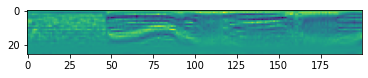

In [ ]:

X_train, energy1 = filterbanks(X_train)
X_test, energy2 = filterbanks(X_test)

X_train = mfcc(X_train, energy1)
X_test = mfcc(X_test, energy2)
'''
X_train = melspec(X_train)
X_test = melspec(X_test)
'''

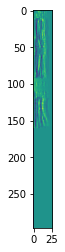

In [ ]:
plt.imshow(X_train[1])

In [ ]:
y_test = np.array(y_test)
y_train = np.expand_dims(y_train, axis=1)
y_test = np.expand_dims(y_test, axis=1)
print(np.shape(X_train), np.shape(y_train), np.shape(X_test), np.shape(y_test))

(8030, 297, 26) (8030, 1) (906, 297, 26) (906, 1)


In [ ]:
class my_data_train():
    def __init__(self,X,Y):
        self.data = X
        self.target = Y 
        self.n_samples = self.data.shape[0]
    
    def __len__(self):  
        return self.n_samples
    
    def __getitem__(self,index): 
        rev = np.random.randint(9, size=1)
        if rev[0] > 4:
          return torch.Tensor(self.data[index]), torch.Tensor(self.target[index])
        else:
          cpy = self.data[index]
          cpy = time_mask(cpy)
          cpy = freq_mask(cpy)
          return torch.Tensor(cpy), torch.Tensor(self.target[index])

class my_data():
    def __init__(self,X,Y):
        self.data = X  
        self.target = Y 
        self.n_samples = self.data.shape[0]
    
    def __len__(self):  
        return self.n_samples
    
    def __getitem__(self,index): 
        return torch.Tensor(self.data[index]), torch.Tensor(self.target[index])

batch=1000
dat = my_data_train(X_train,y_train)
train_loader = data.DataLoader(dat,batch)
dat = my_data(X_test,y_test)
test_loader = data.DataLoader(dat,batch)

In [ ]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        
        self.input_spec_size=26
        self.cnn_filter_size=128
        self.num_layers_lstm=2
        self.num_heads_self_attn=4
        self.hidden_size_lstm=60
        self.num_emo_classes=7
        
        self.conv_1 = nn.Conv1d(self.input_spec_size,self.cnn_filter_size,3,1)
        self.max_pooling_1 = nn.MaxPool1d(5)
        self.bn = nn.BatchNorm1d(self.cnn_filter_size)
        self.conv_2 = nn.Conv1d(self.cnn_filter_size,self.cnn_filter_size,3,1)
        self.max_pooling_2 = nn.MaxPool1d(3)
        
        ###
        self.lstm = nn.LSTM(input_size=self.cnn_filter_size, hidden_size=self.hidden_size_lstm,num_layers=self.num_layers_lstm,bidirectional=True,dropout=0.3,batch_first=True)
        ## Transformer
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=self.hidden_size_lstm*2,dim_feedforward=512, nhead=self.num_heads_self_attn)
        self.emotion_layer = nn.Linear(self.hidden_size_lstm*4,self.num_emo_classes)


    def forward(self,inputs):
        print(np.shape(inputs))
        out = self.conv_1(inputs)
        out = self.max_pooling_1(out)
        out = self.bn(out)
        out = self.conv_2(out)
        #out = self.max_pooling_2(out)
        out = self.bn(out)
        out = out.permute(0, 2, 1)
        out, (final_hidden_state, final_cell_state) = self.lstm(out)
        out = self.encoder_layer(out)
        mean = torch.mean(out,1)
        std = torch.std(out,1)
        stat = torch.cat((mean,std),1)
        pred_emo = self.emotion_layer(stat)
        return pred_emo

In [ ]:
num_epochs = 1500
model = NeuralNet()
lossFunction = nn.CrossEntropyLoss()

In [ ]:
def fit(model, train_loader, test_loader):
  total_step = len(train_loader)
  for epoch in range(num_epochs):
    loss=None
    for i, (data,labels) in enumerate(train_loader):
      #data = data.permute(1,0,2)
      #data = data.unsqueeze(-1)
      data = data.permute(0,2,1)
      labels = labels.view(-1).long()
      #labels= labels.unsqueeze(-1)
      out = model(data)
      loss = lossFunction(out,labels)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

		    
    print('Epoch [{}/{}], Step [{}/{}], Loss: {:.7f}' .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
    eval_test(model,test_loader)

In [ ]:
def eval_test(model,test_loader):
  test_loss = 0
  correct = 0
  j=0
  for i, (data,labels) in enumerate(test_loader):
      #data = data.unsqueeze(-1)
      data = data.permute(0,2,1)
      labels = labels.view(-1).long()
      #labels= labels.unsqueeze(-1)
      net_out = model(data)
      test_loss += lossFunction(net_out, labels).data
      pred = net_out.data.max(1)[1]  
      #for i in range(len(pred)):
        #y_res[j] = pred[i]
        #j += 1
      correct += pred.eq(labels.data).sum()

  test_loss /= len(test_loader.dataset)
  print('Test set: Average loss: {:.7f}, Accuracy: {}/{} ({:.2f}%)\n'.format( test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)

In [ ]:
fit(model,train_loader, test_loader)

In [ ]:
from sklearn.metrics import confusion_matrix
tick_marks = ['ang','dis','fear','hap','neu','sur','sad']
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test, y_res, normalize='true'), annot=True, ax = ax)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.xaxis.set_ticklabels(tick_marks); ax.yaxis.set_ticklabels(tick_marks)


In [ ]:
torch.save(model, 'model_mfcc13.pth')
!cp model_mfcc13.pth drive/My\ Drive/model_mfcc.pth